# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors of the lab : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
    Students solving it: Côme Cothenet, Benjamin Lazard
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [1]:
%matplotlib inline

In [2]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit #enables automatic parallelization and makes code faster

In [3]:
# choose a large font size by default and use tex for math
usetex = True # change this to False if you don't have a working LaTeX environment

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [4]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [5]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [6]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [7]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix

    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [8]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

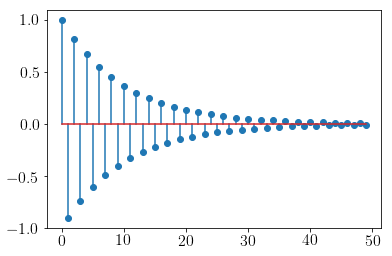

In [9]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [10]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

4.507083210910147e-06

In [11]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.3158225326649357e-07

### Choice of the model

In [12]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [13]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06343552660713836


### Get a very precise minimum to compute distances to minimum

We use scipy function [Limited Memory Broyden–Fletcher–Goldfarb–Shanno Algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS), a quasi-Newton method

In [14]:
# Number of iterations
n_iter = 200

In [15]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30, maxiter=n_iter)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5253661952373534
1.4588033574592418e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

Given a gradient descent algorithm, a loss function and its parameters, this class will keep in memory the history of the values of:
- the minimizer found
- the distance to the minimizer (the one computed above : x_min)
- the distance to the objective(the one computed above : f_min)
- the time elapsed at each new x_min (because the steps do not take the same time for each algorithm)

In [16]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

In [17]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x = x - step * grad(x, *args)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

final distance to x_min: 8.39e-01


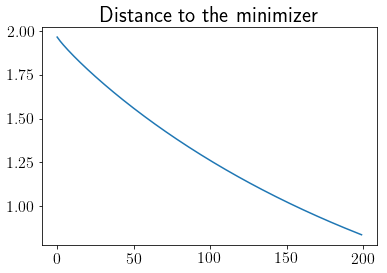

In [18]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b, lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))
print("final distance to x_min: %.2e" % monitor_gd.err[-1])
plt.plot(monitor_gd.err)
plt.title("Distance to the minimizer")
plt.show()

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

In [19]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        xx = y - step * grad(y, *args)
        tt = (1 + (1 + 4 * t**2)**.5) / 2
        y = xx + (t - 1) * (xx - x) / tt
        t, x = tt, xx
    return x, x_list

final distance to x_min: 2.99e-02


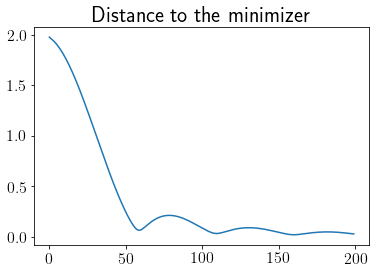

In [20]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))
print("final distance to x_min: %.2e"%monitor_agd.err[-1])
plt.plot(monitor_agd.err)
plt.title("Distance to the minimizer")
plt.show()

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [21]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

         Current function value: 0.525366
         Iterations: 148
         Function evaluations: 240
         Gradient evaluations: 239
final distance to x_min: 1.28e-07


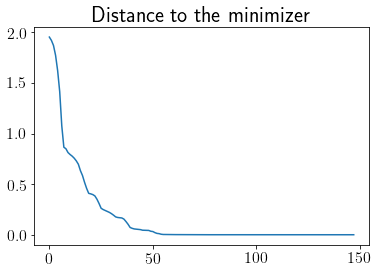

In [22]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)
print("final distance to x_min: %.2e"%monitor_cg.err[-1])
plt.plot(monitor_cg.err)
plt.title("Distance to the minimizer")
plt.show()

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

final distance to x_min: 2.08e-04


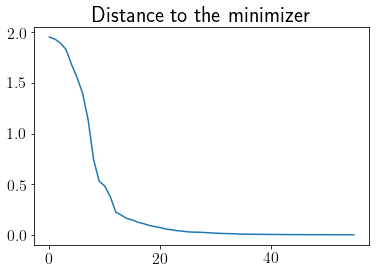

In [23]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b, lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
print("final distance to x_min: %.2e" % monitor_bfgs.err[-1])
plt.plot(monitor_bfgs.err)
plt.title("Distance to the minimizer")
plt.show()

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [24]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)


def plot_time(monitors, solvers):
    plt.figure(figsize=(15, 5))
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

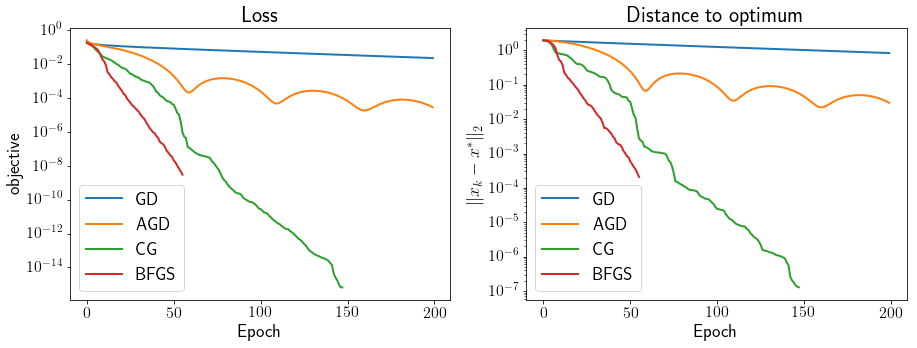

In [25]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

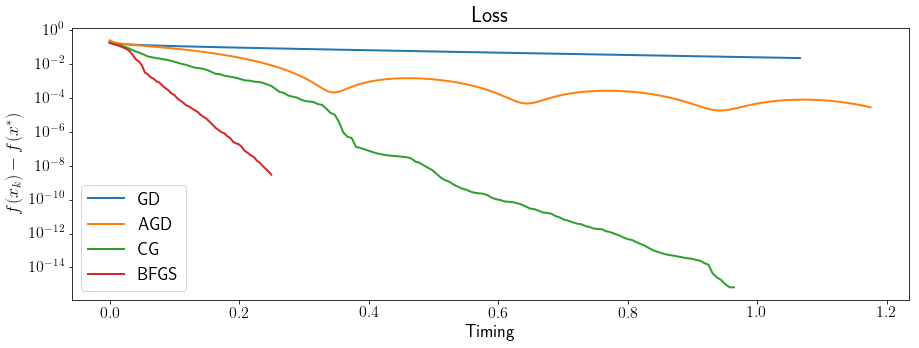

In [26]:
plot_time(monitors, solvers)

### First conclusions

Based on the evaluation of the loss after for a given time. All the previous methods deterministically proven, and will converge to the exact solution.
- **GD** The original Gradient Descent algorithm is the slowest. It is linear in log-domain for strongly convex functions.
- **AGD** The Accelerated Gradient Descent is the 2nd slowest. It is faster than **GD**, yet a phenomenon can be observed: it does not converge monotonically [(see this article)](http://www.seas.ucla.edu/~vandenbe/236C/lectures/fista.pdf), there is a periodic pattern. The *y* variable changes the nature of this algorithm. although convergence is now faster : $O\left(\frac{1}{k^2}\right)$ instead of $O\left(\frac{1}{k}\right)$, it is not longer a pure descent method.
- **CG** The non-linear Conjugate Gradient algorithm reaches the best precision in a near-log-linear fashion. But one must notice that this technique was specifically designed for systems of equations with symetric semi-definite positive matrixes.
- **L-BFGS** The Limited Memory Broyden–Fletcher–Goldfarb–Shanno algorithm is by far the best technique as per speed, but it stops earlier. One must notice that it works especilly fine for such a problem where the hessian is invertible.

<a id='stoc'></a> 
## 4. Stochastic methods

In [27]:
n_iter = 200

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

In [28]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]

        x = x - step / (idx + 1)**.5 * grad_i(i, x, *args)

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

final distance to x_min: 4.49e-02


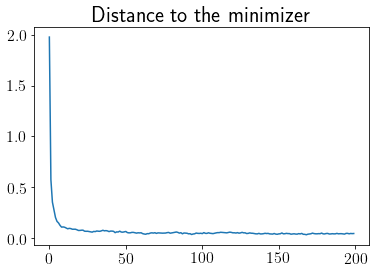

In [29]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b, lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))
print("final distance to x_min: %.2e" % monitor_sgd.err[-1])
plt.plot(monitor_sgd.err)
plt.title("Distance to the minimizer")
plt.show()

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

In [30]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]

        gi_new = grad_i(i, x, *args)
        averaged_gradient = averaged_gradient + (gi_new - gradient_memory[i, :]) / n
        x = x - step * averaged_gradient
        gradient_memory[i, :] = gi_new

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

final distance to x_min: 6.10e-08


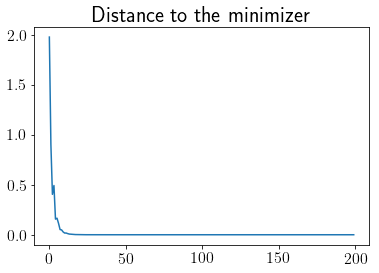

In [31]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b, lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))
print("final distance to x_min: %.2e" % monitor_sag.err[-1])
plt.plot(monitor_sag.err)
plt.title("Distance to the minimizer")
plt.show()

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

In [32]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        μ = grad(x, *args)
        x_old = x.copy()
        for k in range(n):
            i = iis[idx * n + k]
            g = grad_i(i, x, *args) - grad_i(i, x_old, *args) + μ
            x = x - step * g

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

final distance to x_min: 6.10e-08


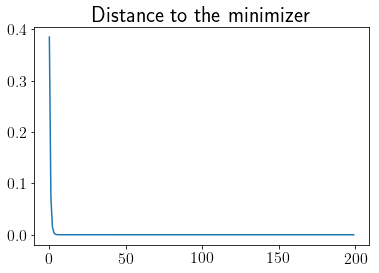

In [33]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b, lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter, step, 1, args=(A, b, lbda))
print("final distance to x_min: %.2e" % monitor_svrg.err[-1])
plt.plot(monitor_svrg.err)
plt.title("Distance to the minimizer")
plt.show()

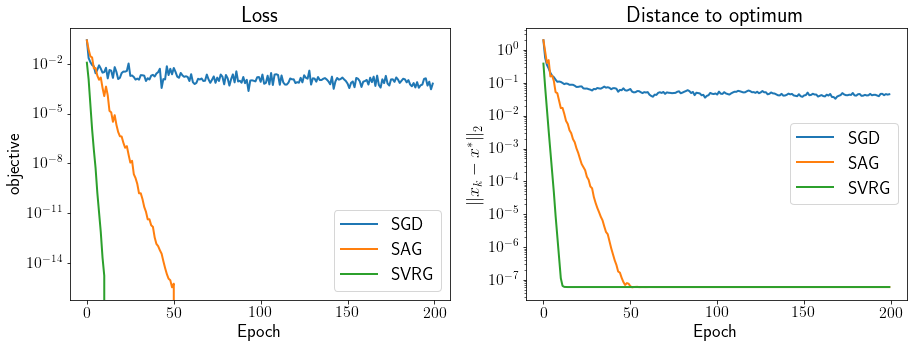

In [34]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

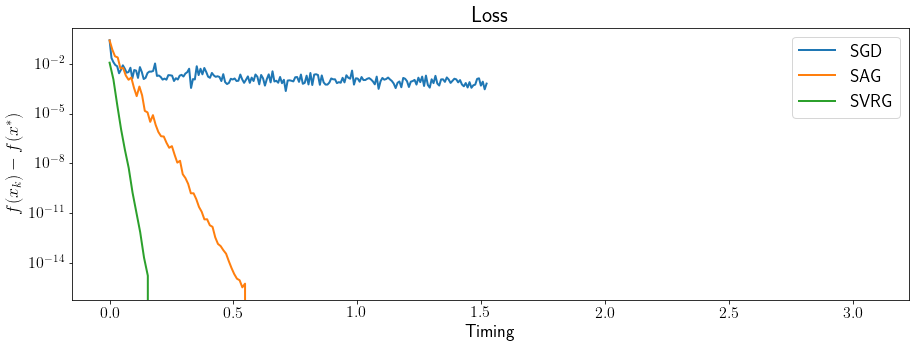

In [35]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

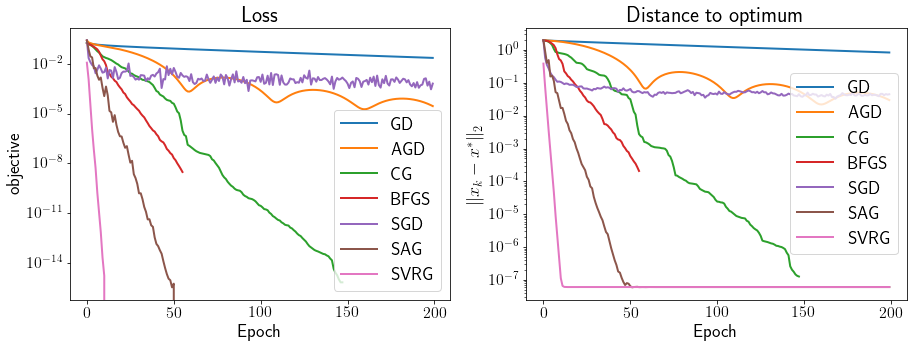

In [36]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

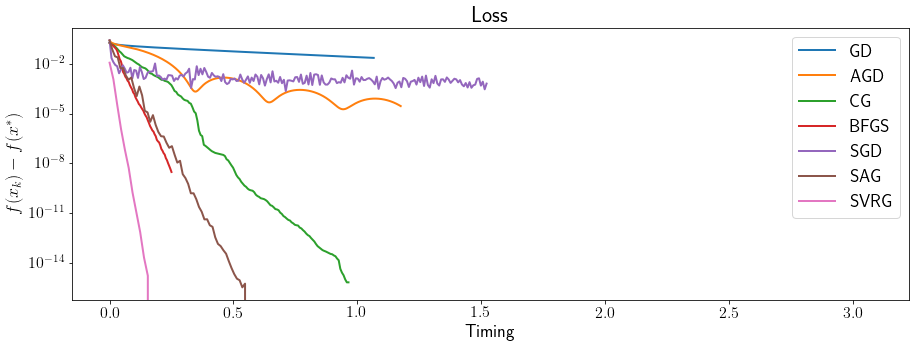

In [37]:
plot_time(monitors, solvers)

<a id='conc'></a> 
## 6. Conclusion

### From the results above, we can see that:
- **SAG** and **SVRG** are the 2 fastest methods for linear regression. But a deeper knowledge of the function to be minimized here leads to **L-BFGS** being faster and more precise than a standard SGD (the step-size is more cleverly computed based on the model). However the stopping criterion of the later makes the solution less accurate. **L-BFGS** is even faster than **SAG** as per time (less memory allocation?)
- **SVRG** is faster than **SAG** here, potentially because it requires less time to store data: only one gradient: $O(d)$ instead of the n previous gradients for SAG : $O(nd)$
- **SGD** is not only faster than **GD**, it is may also be more precise here. We prove mathematically, that the estimate of the gradient based on a subset of the cost functions $f_i$ (here with a batch-size of 1: only one $i$), has the same expectancy than the full computation of the gradient. However, the randomness of $i$ allows for a "jumpy behavior" (variance) around the expectancy, making the algorithm less likely to fall in local extrema.

### Now let us study the impact of the ridge regularization and the correlation of the features :
The previous study was performed with a high ridge regularization: $\lambda = 1 / \sqrt n$... What would happen with a low ridge regularization $\lambda = 1 / n$  ?

Also what if our features were much less correlated than what they are now `corr = .9`?

In [38]:
def master_study(lbda, args):
    ################################################################
    # New parameters
    ################################################################
    x_init = np.zeros(d)
    step = 1. / lipschitz_linreg(A, b, lbda)
    x_min, _, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30, maxiter=200)
    ########################## GD #################################
    monitor_gd = monitor(gd, loss, x_min, args)
    monitor_gd.run(x_init, grad, n_iter, step, args=args)
    ########################## CG #################################
    monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, args)
    monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=args, gtol=1e-9)
    ########################## AGD ################################
    monitor_agd = monitor(agd, loss, x_min, args)
    monitor_agd.run(x_init, grad, n_iter, step, args=args)
    ########################## LBFGS ##############################
    monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
    monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)
    ########################## SGD ################################
    monitor_sgd = monitor(sgd, loss, x_min, args)
    monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=args)
    ########################## SAG ################################
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    step = 1.0 / (max_squared_sum + lbda)
    monitor_sag = monitor(sag, loss, x_min, args)
    monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=args)
    ########################## SVRG ################################
    monitor_svrg = monitor(svrg, loss, x_min, args)
    monitor_svrg.run(x_init, iis, grad, grad_i, n_iter, step, 1, args=args)


    ################################################################
    # Plot
    ################################################################
    monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
                monitor_sgd, monitor_sag, monitor_svrg]

    solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    plot_epochs(monitors, solvers)
    plot_time(monitors, solvers)

#### Low Ridge, High Correlation

         Current function value: 0.491925
         Iterations: 163
         Function evaluations: 298
         Gradient evaluations: 287


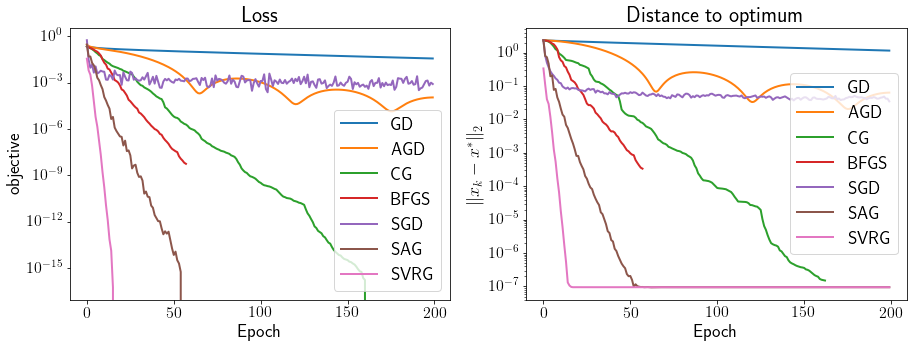

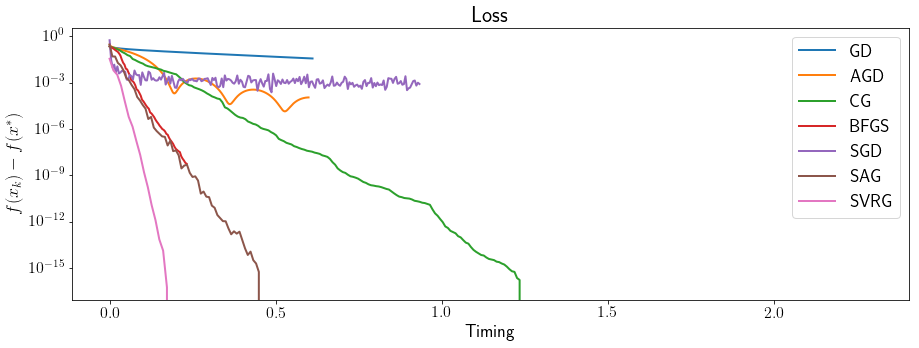

In [39]:
lbda = 1. / n
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
args = (A, b, lbda)
master_study(lbda, args)

There is not much change, the distance  to the solution is not even changed by this new regularization (because n was really big, 1/n**.5 is also big).

#### Low Ridge, Low Correlation

Optimization terminated successfully.
         Current function value: 0.499243
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15


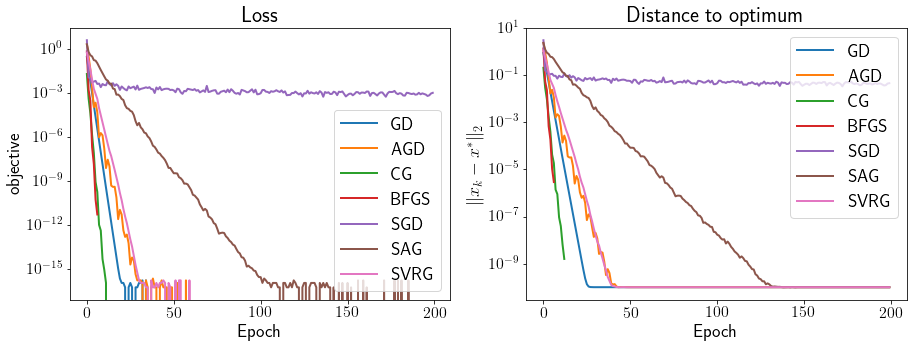

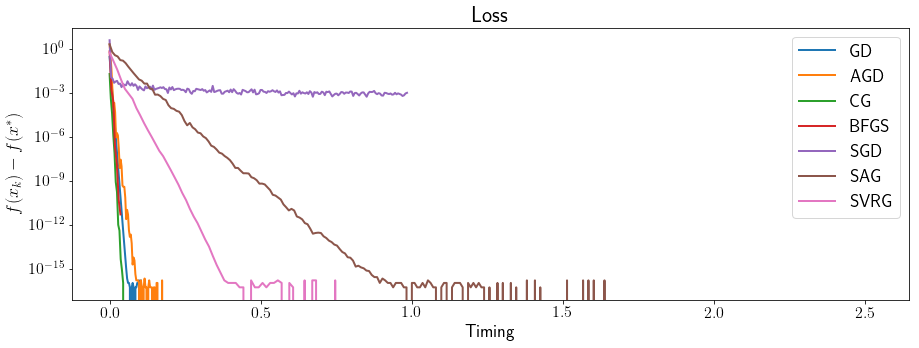

In [40]:
lbda = 1. / n
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
args = (A, b, lbda)
master_study(lbda, args)

The low correlation changes the behavior of most algorithms.

The final solution is found much earlier. As explained in the previous lab, for a given prediction, when variables are less correlated, there are less sets of parameters of the model (coefficients) leading to the same result, making every gradient step taken more meaningful.

- **AGD** illustrates the most this phenomenon as there are less undulations : the path is more direct towards the minimum.
- We can observe that all the deterministic methods perform better than the stochastic ones. In this scenario: each one of the cost functions summed up becomes meaningful, and using a partial information on the gradient (although working just as well, except for **SGD**) happens to be slower.
- **SGD** performs really poorly.
- One might say there is a convergence problem for some methods, but really that is not the case with a stopping criterion of $\epsilon = 10^{-15}$ or a maximum number of epochs, the solution will be very good anyway.

#### High Ridge, Low Correlation

Optimization terminated successfully.
         Current function value: 0.526802
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16


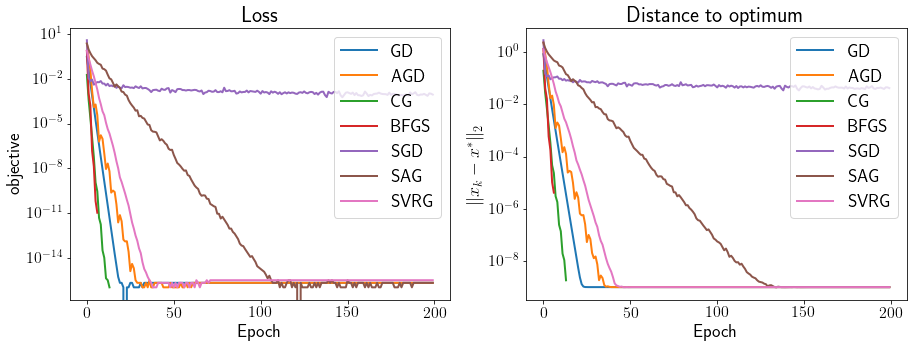

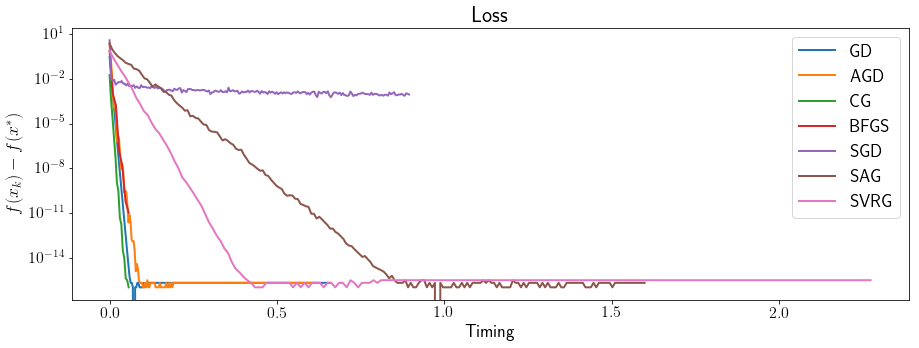

In [41]:
lbda = 1. / n**.5
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
args = (A, b, lbda)
master_study(lbda, args)

As a final conclusion, one may say that only correlation is an important criterion in the choice of algorithms:
- With highly correlated features, stochastic methods perform the best as they avoid "being stuck" in local extrema. **SVRG** seems to be the best choice then (at least for linear models).
- With uncorrelated features, deterministic methods are the best, as each $f_i$ from the cost function is really meaningful, and thus they converge faster. **L-BFGS** seems to be the best choice then (at least for linear models).